# Importy

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics, datasets, svm, preprocessing
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import fetch_openml

# Wprowadzenie do SVM

In [47]:
# Wykorzystamy zestaw danych Iris - zawiera on dane dla próbek z trzech gatunków irysów zawierające 4 pomiary
# dla każdego - długość i szerokość płatka oraz działki kielicha
iris = datasets.load_iris()
X_iris, y_iris = iris.data, iris.target

In [48]:
# Do analizy bierzemy pierwsze dwa mierzone parametry, tzn. długość i szerokość działki kielicha
X, y = X_iris[:, :2], y_iris
y = preprocessing.label_binarize(y, classes=[0, 1, 2])  # aby nie było problemów przy wyznaczaniu ROC
n_classes = y.shape[1]

# Przygotowujemy zbiór testowy
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Dla klasyfikatora użytego w dalszej części wskazana jest normalizacja danych, co też właśnie uczynimy
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 

[]

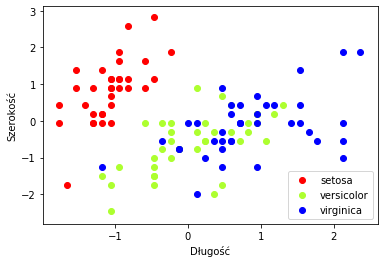

In [49]:
# Wizualizujemy nasz zbiór danych
colors = ['red', 'greenyellow', 'blue']
for i in range(len(colors)):
    px = X_train[:, 0][y_train[:,i] == 1]
    py = X_train[:, 1][y_train[:,i] == 1]
    plt.scatter(px, py, c=colors[i])

plt.legend(iris.target_names)
plt.xlabel('Długość')
plt.ylabel('Szerokość')
plt.plot()

## Klasyfikator liniowy

Jak widać, oddzielenie za pomocą prostej czerwonych punktów od pozostałych nie powinno sprawiać problemów, czego nie można powiedzieć o oddzieleniu pozostałych klas.

In [ ]:
# Tworzymy i trenujemy klasyfikator SGD - Stochastic Gradient Descent
clf = OneVsRestClassifier(linear_model.SGDClassifier())
clf.fit(X_train, y_train)

# Otrzymane współczynniki
print (clf.coef_)
print (clf.intercept_)

In [7]:
# Tworzymy funkcję do wizualizacji wyników (przyda się później)
def draw_results(clf):
    # Nanosimy na wykres punkty z całego zbioru
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y[:,i] == 1)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i])
    plt.axis('tight')  # ta opcja zapewnia "nierozjechanie" się wykresu po dodaniu prostych

    # Dodajemy otrzymane z klasyfikacji linie proste
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coefficients = clf.coef_
    intercept = clf.intercept_

    def plot_line(index, color):
        def line(x0):
            return (-(x0 * coefficients[index, 0]) - intercept[index]) / coefficients[index, 1]

        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)


    for i, color in zip(clf.classes_, colors):
        plot_line(i, color)
    plt.legend()
    plt.show()

In [ ]:
# Wizualizujemy wyniki
draw_results(clf)

In [ ]:
# Sprawdźmy dokładność
y_predicted = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_predicted))

## Klasyfikator SVM

In [ ]:
# Tworzymy liniowy klasyfikator SVM
linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear")).fit(X_train, y_train)
draw_results(linear_svc)

In [ ]:
# Sprawdzamy dokładność
y_predicted = linear_svc.predict(X_test)
print(metrics.accuracy_score(y_test, y_predicted))

## Trik kernelowy

Stosowanie wyłącznie liniowych funkcji jest dość ograniczające. W sytuacjach, gdy takie podejście jest niewystarczające z pomocą przychodzi tzw. trik kernelowy - matematycznie polega on na transformacji danych do wyżej wymiarowej przestrzeni, w której można znaleźć hiperpłaszczyznę separującą dane.

In [8]:
# Zawczasu przygotujmy sobie funkcję rysującą nieliniowe kontury
def draw_nonlinear_results(clf, h=0.05):
    # Nanosimy na wykres punkty z całego zbioru
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y[:,i] == 1)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i])
    plt.axis('tight')  # ta opcja zapewnia "nierozjechanie" się wykresu po dodaniu prostych

    # Dodajemy otrzymane z klasyfikacji linie proste
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    # Tworzymy siatkę do narysowania konturów
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h),
                         np.arange(ymin, ymax, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    index_list = [np.where(i == np.amax(i)) for i in Z]
    Z = list(map(lambda x: list(x[0]), index_list))
    Z = np.array([x[0] if x else 3 for x in Z])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors=colors, linestyles="--")

In [ ]:
# Spróbujmy zastosować wielomian
degree = 3
gamma = 0.9
polynomial_clf = OneVsRestClassifier(svm.SVC(kernel="poly", degree=degree, gamma=gamma, probability=True))
polynomial_clf.fit(X_train, y_train)

draw_nonlinear_results(polynomial_clf)

In [ ]:
# Sprawdzamy dokładność
y_predicted = polynomial_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_predicted))

In [ ]:
# Innym możliwym wyborem jest kernel RBF
rbf_clf = OneVsRestClassifier(svm.SVC(kernel="rbf", gamma=gamma, probability=True))
rbf_clf.fit(X_train, y_train)
draw_nonlinear_results(rbf_clf)

In [ ]:
# Sprawdzamy dokładność
y_predicted = rbf_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_predicted))

## Badanie jakości klasyfikacji

In [9]:
# ROC
def determine_roc(clf, title=""):
    y_score = clf.decision_function(X_test)
    
    # wyznaczamy tpr i fpr dla wszystkich klas osobno
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(0, n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # wartości micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # wartości zbiorcze
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))    
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # rysowanie wykresu
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-uśredniona krzywa ROC (pole = {0:0.2f})'
            ''.format(roc_auc["micro"]),
            color="deeppink", linestyle=":", linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-uśredniona krzywa ROC (pole = {0:0.2f})'
            ''.format(roc_auc["macro"]),
            color="navy", linestyle=":", linewidth=4)
    
    for i, color in zip(range(0, n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
                label="ROC dla klasy {} (pole = {:0.2f})"
                "".format(i, roc_auc[i]))
    
    plt.plot([0,1], [0,1], "k--", linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False positive")
    plt.ylabel("True positive")
    plt.legend(loc="lower right")
    plt.title(title)
    plt.show() 

In [ ]:
# ROC dla naszych klasyfikatorów
determine_roc(clf, "Klasyfikator liniowy")
determine_roc(linear_svc, "Liniowy SVM")
determine_roc(polynomial_clf, "Wielomian")
determine_roc(rbf_clf, "RBF")

In [10]:
# Precision-recall
def determine_precision_recall(clf, title):
    y_score = clf.decision_function(X_test)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                           y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        
    # micro średnia
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
                                                                   y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                        average="micro")
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    lines.append(l)
    labels.append("Krzywe Iso-F1")
    l, = plt.plot(recall["micro"], precision["micro"], color="gold", linewidth=2)
    lines.append(l)
    labels.append("Micro-średni precision-recall (pole = {:0.2f})"
                 "".format(average_precision["micro"]))
    
    for i, color in zip(range(0, n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall dla klasy {} (pole = {:0.2f})'
                  ''.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -0.38), prop=dict(size=14))
    plt.show()

In [ ]:
# Precision-recall dla naszych klasyfikatorów
determine_precision_recall(clf, "Klasyfikator liniowy")
determine_precision_recall(linear_svc, "Liniowy SVM")
determine_precision_recall(polynomial_clf, "Wielomian")
determine_precision_recall(rbf_clf, "RBF")

# 2. Działanie klasyfikatora SVM

Użyjemy tutaj zbioru WBC (wisconsin breast cancer)


In [50]:
#ładownie danych
wbc = datasets.load_breast_cancer()
x_wbc, y_wbc = wbc.data[:300], wbc.target[:300]

y_wbc = preprocessing.label_binarize(y_wbc, classes=[0, 1, 2])  # aby nie było problemów przy wyznaczaniu ROC
y_wbc = y_wbc[:, :2]
n_classes = y_wbc.shape[1]

# Przygotowujemy zbiór testowy
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_wbc, y_wbc, test_size=test_size)

# Dla klasyfikatora użytego w dalszej części wskazana jest normalizacja danych, co też właśnie uczynimy
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
x_wbc = scaler.transform(x_wbc)

In [ ]:
# użyjemy trzech różnych kerneli: linear, rbf i poly

#linear
linear_svc = OneVsRestClassifier(svm.SVC(kernel="linear")).fit(X_train, y_train)
y_predicted_linear = linear_svc.predict(X_test)

#wielomian
degree = 3
gamma = 0.9
polynomial_clf = OneVsRestClassifier(svm.SVC(kernel="poly", degree=degree, gamma=gamma, probability=True))
polynomial_clf.fit(X_train, y_train)
y_predicted_poly = polynomial_clf.predict(X_test)

#rbf
rbf_clf = OneVsRestClassifier(svm.SVC(kernel="rbf", gamma=gamma, probability=True))
rbf_clf.fit(X_train, y_train)
y_predicted_rbf = rbf_clf.predict(X_test)

In [ ]:
# Sprawdzamy najpierw dokładność wszystkich trzech kerneli

print("Dokładność dla linear: ")
print(metrics.accuracy_score(y_test, y_predicted_linear))
print("Dokładność dla poly: ")
print(metrics.accuracy_score(y_test, y_predicted_poly))
print("Dokładność dla rbf: ")
print(metrics.accuracy_score(y_test, y_predicted_rbf))

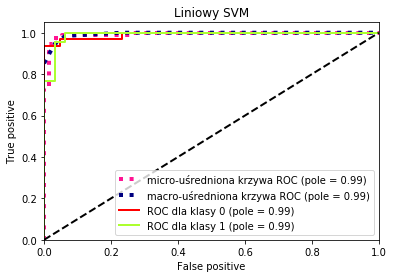

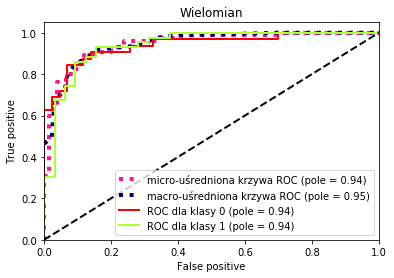

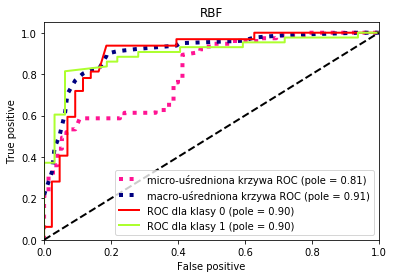

In [53]:
# dokonamy teraz walidacji krzyżowej:

# ROC wraz z polem pod wykresem
determine_roc(linear_svc, "Liniowy SVM")
determine_roc(polynomial_clf, "Wielomian")
determine_roc(rbf_clf, "RBF")

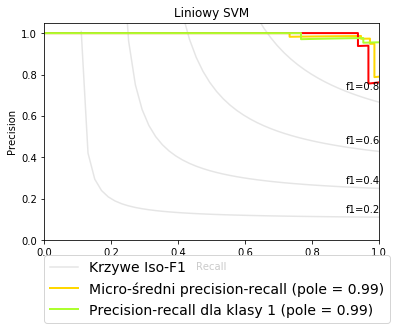

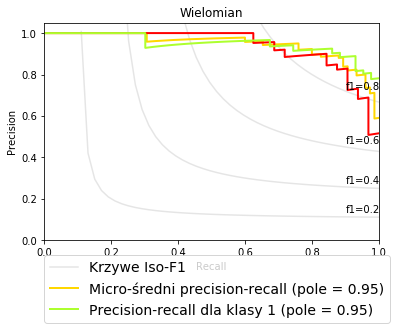

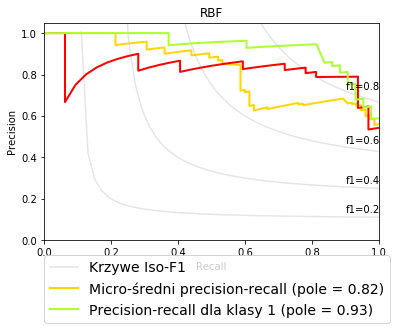

In [54]:
# PR wraz z miarą F-1
determine_precision_recall(linear_svc, "Liniowy SVM")
determine_precision_recall(polynomial_clf, "Wielomian")
determine_precision_recall(rbf_clf, "RBF")

# 3. PCA




# 4. Zadanie

Na zbiorze MNIST dokonaj klasyfikacji metodą SVM dla dwóch kerneli (POLY oraz RBF), a także
metodą k-NN sla k-1, 3 i 5.
Podglądnij otrzymane wyniki przy pomocy PCA (skozystaj z kodu z poprzednich punktów)

Następnie skomentuj otrzymane wyniki



In [57]:
# code

# pobranie danych
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

elements = 1000
test_size = 0.25

m_data = mnist.data[:elements]
m_target = mnist.target[:elements]

X_train, X_test, y_train, y_test = train_test_split(m_data, m_target, test_size=test_size)

# normalizacja
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



# wykorzystaj klasyfikatory z punktu 2.
# todo
# np
# class_rbf = ...

# knn classifier - przypomnienie
# knn = KNeighborsClassifier(n_neighbors=7)


# wykorzystaj SVM z poprzedniego punktu



1000


Komentarz:
<uzupełnij>

Zrób to samo, lecz tym razem zredukuj wymiarowość danych do 40 wymiarów metodą PCA.
Czy wyniki uległy poprawie? Jeśli tak, to dlaczego? Skomentuj otrzymane wyniki.


In [ ]:
# code

# redukcja wymiarów:
pca = PCA(n_components=40)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# ...


Komentarz:
<uzupełnij>


# Opracowano na podstawie
* https://en.wikipedia.org/wiki/Iris_flower_data_set
* https://adataanalyst.com/scikit-learn/linear-classification-method/
* https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html
* https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_iris.html
* https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989
* https://towardsdatascience.com/understanding-support-vector-machine-part-1-lagrange-multipliers-5c24a52ffc5e
* https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


